The 0.02s overlap does not work well. The goal of this notebook is to see what kind of result could be extracted of such as case. The two main hypotheses are to find a third signal at the end or only one but with much bigger masses at the start. So we explore different work hypotheses to see what happens. However, it is important to note that in any case, we can see that the analysis reports weird results.

## 3 signals

In [1]:
# Beautiful plots
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter, highpass
import numpy as np
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import sigma

In [3]:
merger = Merger("GW150914")
strain = merger.strain('H1')
strain = highpass(strain, 15)
strain = strain.crop(2,2)

strainF = strain.to_frequencyseries()

In [4]:
#best fit template of the event, as found in the previous notebook

#freq
hp_f, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                                delta_f = strainF.delta_f)
hp_f.resize(len(strainF))
hp_f.start_time = strainF.start_time

#time
hp_t, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                         delta_t = strain.delta_t)
hp_t.resize(len(strain))
hp_t.start_time = strain.start_time

In [5]:
# making the signal with the injection at 0.02 sec
time_shifts = np.arange(5, 20, 0.01)

model_inj = None
max_amp_inj, time_inj, time_dif = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                              mass2 = 32.3, distance = 440, f_lower = 20.,
                              delta_t = strain.delta_t)
    hpInj.resize(len(strain))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strain.start_time
    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_ev = hpInj.sample_times[ind]
    time_diff = time_ev - merger.time
    if (abs(time_diff - 0.02) < 0.01):
        model_inj = hpInj
        max_amp_inj, time_inj, time_dif_inj = max_amp, time_ev, time_diff


In [6]:
#infos about the injection
print("Max amplitude: ", max_amp_inj)
print("time of the merger for the injection: ", time_inj)
print("Time gap between merger and injection: ", time_dif_inj)

('Max amplitude: ', 1.820726655022926e-21)
('time of the merger for the injection: ', 1126259462.4284668)
('Time gap between merger and injection: ', 0.02846670150756836)


In [7]:
#now we add the injection in the strain 

sig02 = strain + model_inj

sigF02 = sig02.to_frequencyseries()

p0 = sig02.psd(2)
p0 = interpolate(p0, sig02.delta_f)
psd02 = inverse_spectrum_truncation(p0, 2*sig02.sample_rate, 
                                 low_frequency_cutoff = 20.)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


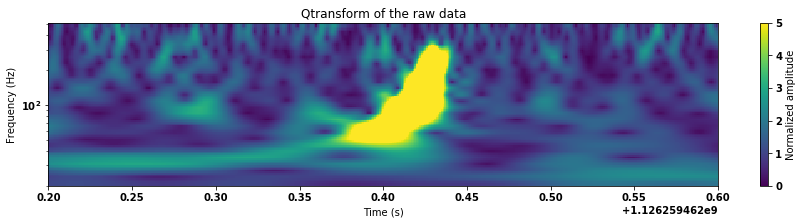

In [8]:
zoom = sig02.whiten(2,2).time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,512),
                             qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [9]:
import numpy as np

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.7, 32.4, 0.1)

hmax02 = None
maxsnr02, m1max02, m2max02, tmax02 = 0, 0, 0, 0

snrs02 = [[] for i in range(len(mass1))]
max_snrs02 = [[] for i in range(len(mass1))]
times_max02 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF02.delta_f)
        hp.resize(len(sigF02))
        
        snr = matched_filter(hp, sigF02, psd = psd02, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 5, merger.time + 5)
        snrs02[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs02[i].append(snrp)
        time = snr.sample_times[idx]
        times_max02[i].append(time)
        
        # Keep track of the max snr
        
        if snrp > maxsnr02:
            tmax02, hmax02, m1max02, m2max02, maxsnr02 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1max02, m2max02, tmax02, maxsnr02))
print(time_inj)

mass 1 1/79
Done
mass 1 2/79
Done
mass 1 3/79
Done
mass 1 4/79
Done
mass 1 5/79
Done
mass 1 6/79
Done
mass 1 7/79
Done
mass 1 8/79
Done
mass 1 9/79
Done
mass 1 10/79
Done
mass 1 11/79
Done
mass 1 12/79
Done
mass 1 13/79
Done
mass 1 14/79
Done
mass 1 15/79
Done
mass 1 16/79
Done
mass 1 17/79
Done
mass 1 18/79
Done
mass 1 19/79
Done
mass 1 20/79
Done
mass 1 21/79
Done
mass 1 22/79
Done
mass 1 23/79
Done
mass 1 24/79
Done
mass 1 25/79
Done
mass 1 26/79
Done
mass 1 27/79
Done
mass 1 28/79
Done
mass 1 29/79
Done
mass 1 30/79
Done
mass 1 31/79
Done
mass 1 32/79
Done
mass 1 33/79
Done
mass 1 34/79
Done
mass 1 35/79
Done
mass 1 36/79
Done
mass 1 37/79
Done
mass 1 38/79
Done
mass 1 39/79
Done
mass 1 40/79
Done
mass 1 41/79
Done
mass 1 42/79
Done
mass 1 43/79
Done
mass 1 44/79
Done
mass 1 45/79
Done
mass 1 46/79
Done
mass 1 47/79
Done
mass 1 48/79
Done
mass 1 49/79
Done
mass 1 50/79
Done
mass 1 51/79
Done
mass 1 52/79
Done
mass 1 53/79
Done
mass 1 54/79
Done
mass 1 55/79
Done
mass 1 56/79
Done
m

Text(0,0.5,'Normalized amplitude')

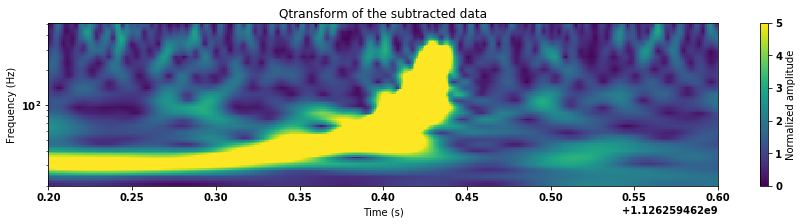

In [10]:
#try to subract with the first results

#subtraction of the signal to see if it works

dt = tmax02 - sigF02.start_time
inj = hmax02.cyclic_time_shift(dt)

#scaling of the template 
inj /= sigma(hmax02, psd = psd02, low_frequency_cutoff = 20.)
inj *= maxsnr02

#subtraction
subF02 = sigF02 - inj

#whiten
subT_white02 = (subF02/psd02**0.5).to_timeseries()
zoom = subT_white02.time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [11]:
f_low = 20.
f_upper = 1024.

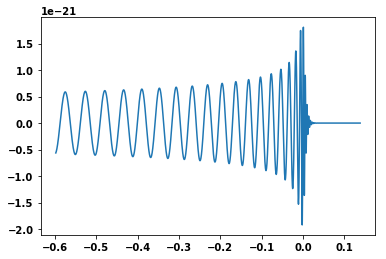

In [12]:
#strting model that wil be adjusted:

hp_st02, hf_st02 = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1max02,
                              mass2 = m2max02, distance = 440, delta_t = sig02.delta_t,
                              f_lower = f_low)
plt.plot(hp_st02.sample_times, hp_st02)

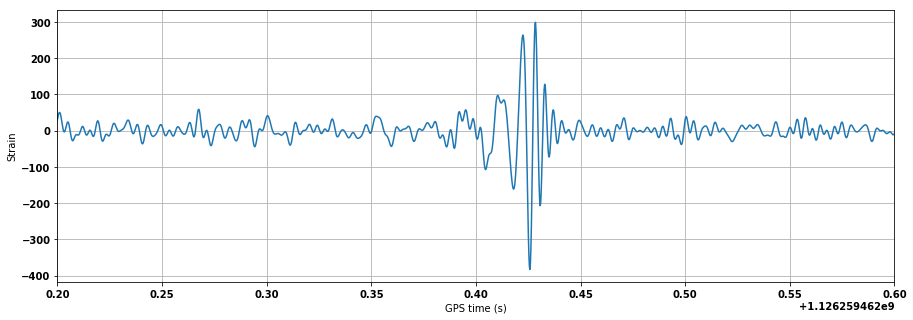

In [13]:
#whitening of the data
white_sig02 =  (sigF02/psd02**0.5).to_timeseries()
white_sig02 = white_sig02.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sig02 = white_sig02.time_slice(merger.time - 5, merger.time + 5)

plt.figure(figsize = [15, 5])
plt.plot(white_sig02.sample_times, white_sig02)
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()

In [14]:
def gen_template(theta, delta_t = sig02.delta_t, 
                 duration = sig02.duration, start_time = sig02.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sig02.start_time)
    hp.start_time = sig02.start_time
    
    return hp

In [15]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = sigF02, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psd02[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd02[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [16]:
def whiten_trim_template(template, psd = psd02):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd02**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (sigF02/psd02**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd02 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 5)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + 0.2)
    if zoom is False:
        plt.xlim(merger.time - 0.5, merger.time + 0.5)
        

-678.4668318033355


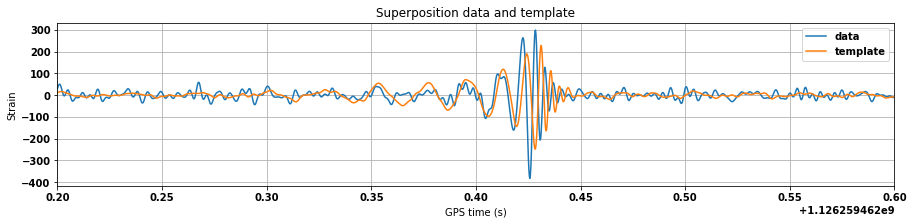

In [17]:
theta0 = [m1max02, m2max02, 440, tmax02]

temp0 = gen_template(theta0)
plot_white_strain(sig02, temp0, True)

print(loglikelihood(theta0))

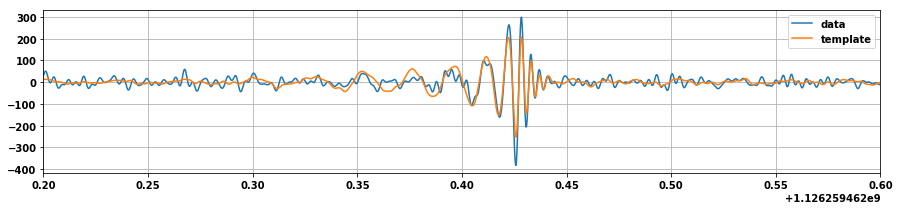

Steps 	 log(likelihood)
9 	 597.119


In [18]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sig02.sample_times, white_sig02, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.07558253e+01 3.22164232e+01 4.45477669e+02 1.12625946e+09]


Text(0.5,1,'Superposition sugnal and best fit template')

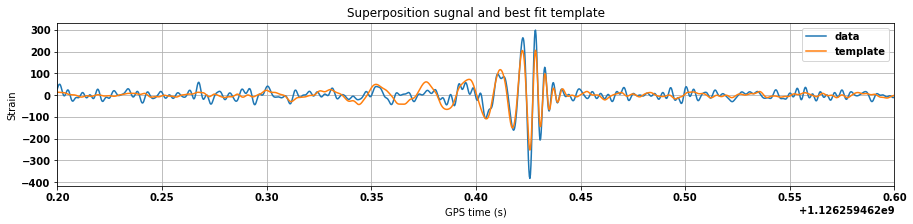

In [19]:
para02 = res.x
print(para02)
best_temp02 = gen_template(para02)
plot_white_strain(sig02, best_temp02, True)
plt.title("Superposition sugnal and best fit template")

Text(0,0.5,'Normalized amplitude')

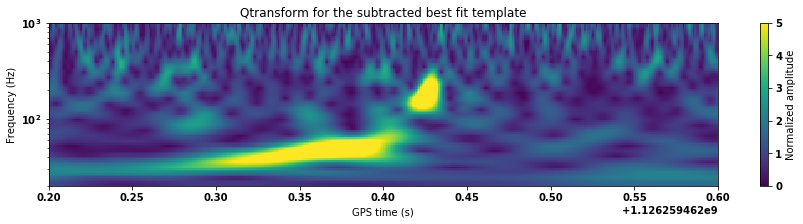

In [20]:
#subtraction

#try to subtract the best fit template to see if it works

sub02 = sig02 - best_temp02

t, f, p = sub02.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

The signal is only partially subtracted, with a gap in between. May be it would be bette subtracted for larger masses or other wave forms.

We try to **subtract the remaining signal**

In [21]:
print(type(sub02))

<class 'pycbc.types.timeseries.TimeSeries'>


In [22]:
#frequecy domain subtracted data
subF02 = sub02.to_frequencyseries()

#PSD of the subtracted data
ps2 = sub02.psd(2)
ps2 = interpolate(ps2, sub02.delta_f)
psdS2 = inverse_spectrum_truncation(ps2, 2*sub02.sample_rate, 
                                   low_frequency_cutoff = 15.,
                                   trunc_method = 'hann')

(20.0, 2048.0)

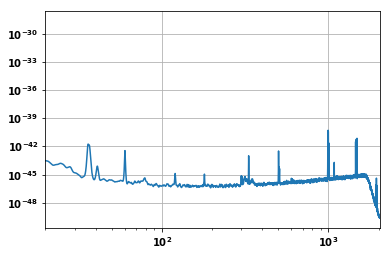

In [27]:
plt.loglog(psdS2.sample_frequencies, psdS2)
plt.grid()
plt.xlim(20., 2048.)

In [28]:
#best mass for the event

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.1, 32.4, 0.1)

hmaxS02 = None
maxsnrS02, m1maxS02, m2maxS02, tmaxS02 = 0, 0, 0, 0

snrsS02 = [[] for i in range(len(mass1))]
max_snrsS02 = [[] for i in range(len(mass1))]
time_maxS02 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1,len(mass1)))
    for m2 in mass2:
        #template generation
        hp, _ = get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = subF02.delta_f)
        hp.resize(len(subF02))
        
        #matched filtering
        snr = matched_filter(hp, subF02, psd = psdS2, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrsS02[i].append(snr)
        ind = abs(snr).numpy().argmax()
        snrp = abs(snr[ind])
        max_snrsS02[i].append(snrp)
        time = snr.sample_times[ind]
        time_maxS02[i].append(time)
        
        #keep track of max snr
        
        if snrp > maxsnrS02:
            tmaxS02, hmaxS02, m1maxS02, m2maxS02, maxsnrS02 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a value of %.7f" %(m1maxS02, m2maxS02, tmaxS02, maxsnrS02))
print(merger.time)

Mass 1: 1/79
Done
Mass 1: 2/79
Done
Mass 1: 3/79
Done
Mass 1: 4/79
Done
Mass 1: 5/79
Done
Mass 1: 6/79
Done
Mass 1: 7/79
Done
Mass 1: 8/79
Done
Mass 1: 9/79
Done
Mass 1: 10/79
Done
Mass 1: 11/79
Done
Mass 1: 12/79
Done
Mass 1: 13/79
Done
Mass 1: 14/79
Done
Mass 1: 15/79
Done
Mass 1: 16/79
Done
Mass 1: 17/79
Done
Mass 1: 18/79
Done
Mass 1: 19/79
Done
Mass 1: 20/79
Done
Mass 1: 21/79
Done
Mass 1: 22/79
Done
Mass 1: 23/79
Done
Mass 1: 24/79
Done
Mass 1: 25/79
Done
Mass 1: 26/79
Done
Mass 1: 27/79
Done
Mass 1: 28/79
Done
Mass 1: 29/79
Done
Mass 1: 30/79
Done
Mass 1: 31/79
Done
Mass 1: 32/79
Done
Mass 1: 33/79
Done
Mass 1: 34/79
Done
Mass 1: 35/79
Done
Mass 1: 36/79
Done
Mass 1: 37/79
Done
Mass 1: 38/79
Done
Mass 1: 39/79
Done
Mass 1: 40/79
Done
Mass 1: 41/79
Done
Mass 1: 42/79
Done
Mass 1: 43/79
Done
Mass 1: 44/79
Done
Mass 1: 45/79
Done
Mass 1: 46/79
Done
Mass 1: 47/79
Done
Mass 1: 48/79
Done
Mass 1: 49/79
Done
Mass 1: 50/79
Done
Mass 1: 51/79
Done
Mass 1: 52/79
Done
Mass 1: 53/79
Done
Ma

Text(0,0.5,'Normalized amplitude')

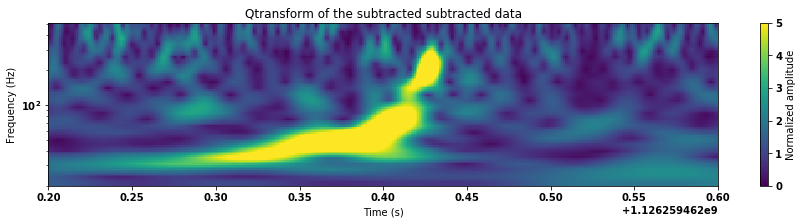

In [29]:
#trial of direct subtraction

dt = tmaxS02 - subF02.start_time
inj = hmaxS02.cyclic_time_shift(dt)

#scale tempplate

inj /= sigma(hmaxS02, psd = psdS2, low_frequency_cutoff = 20.)
inj *= maxsnrS02

subsubF02 = subF02 - inj

#whiten 

subsub_white02 = (subsubF02/psdS2**0.5).to_timeseries()
zoom = subsub_white02.time_slice(merger.time -2, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))

plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

The direct subtraction does not work. So we try the direct subtraction at the end.

Text(0.5,1,'Whitened data of GW150914 with the signal injected at 0.02s, after subtraction')

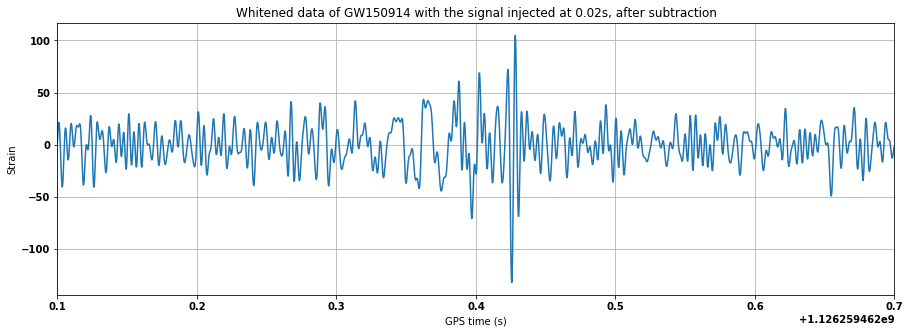

In [30]:
#whiten the subtracted data

white_sigS02 =  (subF02/psdS2**0.5).to_timeseries()
white_sigS02 = white_sigS02.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sigS02 = white_sigS02.time_slice(merger.time - 5, merger.time + 5)

plt.figure(figsize = [15, 5])
plt.plot(white_sigS02.sample_times, white_sigS02)
plt.xlim(merger.time - 0.3, merger.time + .3)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()
plt.title("Whitened data of GW150914 with the signal injected at 0.02s, after subtraction")

In [31]:
def gen_template(theta, delta_t = sub02.delta_t, 
                 duration = sub02.duration, start_time = sub02.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sub02.start_time)
    hp.start_time = sub02.start_time
    
    return hp

In [33]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = subF02, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psdS2[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psdS2[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [34]:
def whiten_trim_template(template, psd = psdS2):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (subF02/psdS2**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psdS2 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 5)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + 0.2)
    if zoom is False:
        plt.xlim(merger.time - 0.5, merger.time + 0.5)
        

-654.4746171434058


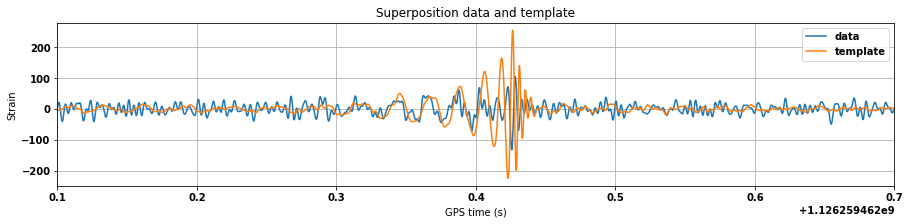

In [39]:
theta0 = [m1maxS02, m2maxS02, 440, tmaxS02]

temp0 = gen_template(theta0)
plot_white_strain(sub02, temp0, True)
plt.xlim(merger.time - 0.3, merger.time + 0.3)

print(loglikelihood(theta0))

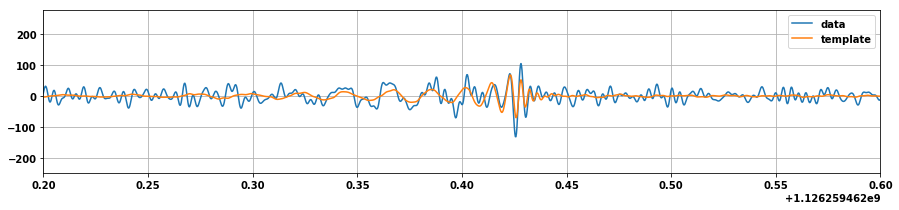

Steps 	 log(likelihood)
6 	 54.622


In [40]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sigS02.sample_times, white_sigS02, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.10038389e+01 1.96791256e+01 1.15123233e+03 1.12625946e+09]


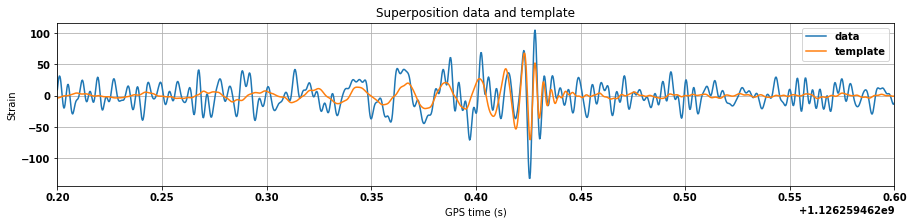

In [41]:
paramS02 = res.x
print(paramS02)
bestSub02 = gen_template(paramS02)
plot_white_strain(sub02, bestSub02, True)

Text(0,0.5,'Normalized amplitude')

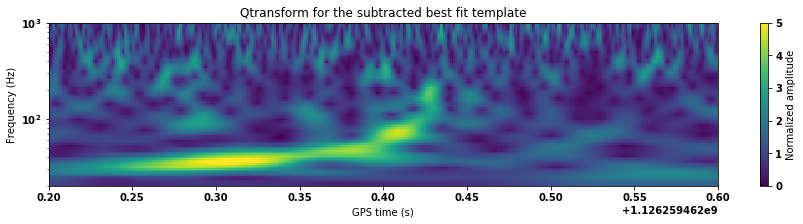

In [42]:
subsub02 = sub02 - bestSub02

t, f, p = subsub02.whiten(2,2).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

When the best fit is done, there seems to still be an event present. So, we can look to the possibility to detect a third event

In [45]:
#to frequency
subsubF02 = subsub02.to_frequencyseries()

#PSD of the subsub data
pps = subsub02.psd(2)
pps = interpolate(pps, subsub02.delta_f)
psdSS02 = inverse_spectrum_truncation(pps, 2*subsub02.sample_rate,
                                     low_frequency_cutoff = 15.,
                                     trunc_method = 'hann')

(20.0, 2048.0)

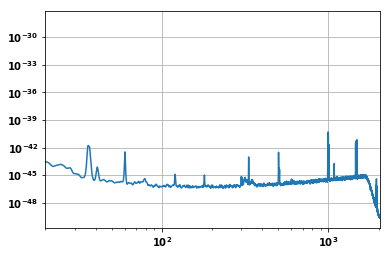

In [47]:
plt.loglog(psdSS02.sample_frequencies, psdSS02)
plt.grid()
plt.xlim(20., 2048.)

In [50]:
#matched filtering for the event

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.1, 32.4, 0.1)

hmaxSS02 = None
maxsnrSS02, m1maxSS02, m2maxSS02, tmaxSS02 = 0, 0, 0, 0

snrsSS02 = [[] for i in range(len(mass1))]
max_snrsSS02 = [[] for i in range(len(mass1))]
time_maxSS02 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1,len(mass1)))
    for m2 in mass2:
        #template generation
        hp, _ = get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = subsubF02.delta_f)
        hp.resize(len(subsubF02))
        
        #matched filtering
        snr = matched_filter(hp, subsubF02, psd = psdSS02, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrsSS02[i].append(snr)
        ind = abs(snr).numpy().argmax()
        snrp = abs(snr[ind])
        max_snrsSS02[i].append(snrp)
        time = snr.sample_times[ind]
        time_maxSS02[i].append(time)
        
        #keep track of max snr
        
        if snrp > maxsnrSS02:
            tmaxSS02, hmaxSS02, m1maxSS02, m2maxSS02, maxsnrSS02 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a value of %.7f" %(m1maxSS02, m2maxSS02, tmaxSS02, maxsnrSS02))
print(merger.time)

Mass 1: 1/79
Done
Mass 1: 2/79
Done
Mass 1: 3/79
Done
Mass 1: 4/79
Done
Mass 1: 5/79
Done
Mass 1: 6/79
Done
Mass 1: 7/79
Done
Mass 1: 8/79
Done
Mass 1: 9/79
Done
Mass 1: 10/79
Done
Mass 1: 11/79
Done
Mass 1: 12/79
Done
Mass 1: 13/79
Done
Mass 1: 14/79
Done
Mass 1: 15/79
Done
Mass 1: 16/79
Done
Mass 1: 17/79
Done
Mass 1: 18/79
Done
Mass 1: 19/79
Done
Mass 1: 20/79
Done
Mass 1: 21/79
Done
Mass 1: 22/79
Done
Mass 1: 23/79
Done
Mass 1: 24/79
Done
Mass 1: 25/79
Done
Mass 1: 26/79
Done
Mass 1: 27/79
Done
Mass 1: 28/79
Done
Mass 1: 29/79
Done
Mass 1: 30/79
Done
Mass 1: 31/79
Done
Mass 1: 32/79
Done
Mass 1: 33/79
Done
Mass 1: 34/79
Done
Mass 1: 35/79
Done
Mass 1: 36/79
Done
Mass 1: 37/79
Done
Mass 1: 38/79
Done
Mass 1: 39/79
Done
Mass 1: 40/79
Done
Mass 1: 41/79
Done
Mass 1: 42/79
Done
Mass 1: 43/79
Done
Mass 1: 44/79
Done
Mass 1: 45/79
Done
Mass 1: 46/79
Done
Mass 1: 47/79
Done
Mass 1: 48/79
Done
Mass 1: 49/79
Done
Mass 1: 50/79
Done
Mass 1: 51/79
Done
Mass 1: 52/79
Done
Mass 1: 53/79
Done
Ma

Text(0,0.5,'Normalized amplitude')

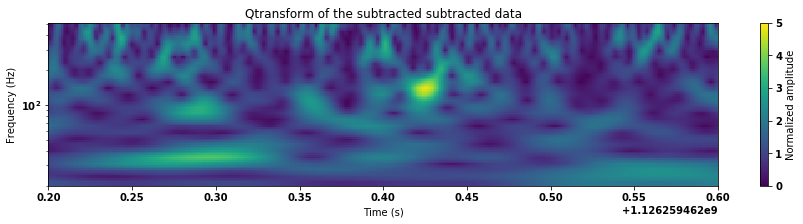

In [51]:
#trial of direct subtraction

dt = tmaxSS02 - subsubF02.start_time
inj = hmaxSS02.cyclic_time_shift(dt)

#scale tempplate

inj /= sigma(hmaxSS02, psd = psdSS02, low_frequency_cutoff = 20.)
inj *= maxsnrS02

subsubSF02 = subsubF02 - inj

#whiten 

subsub_whiteSS02 = (subsubSF02/psdSS02**0.5).to_timeseries()
zoom = subsub_whiteSS02.time_slice(merger.time -2, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))

plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

Text(0.5,1,'Whitened data of GW150914 with the signal injected at 0.02 s after second subtraction')

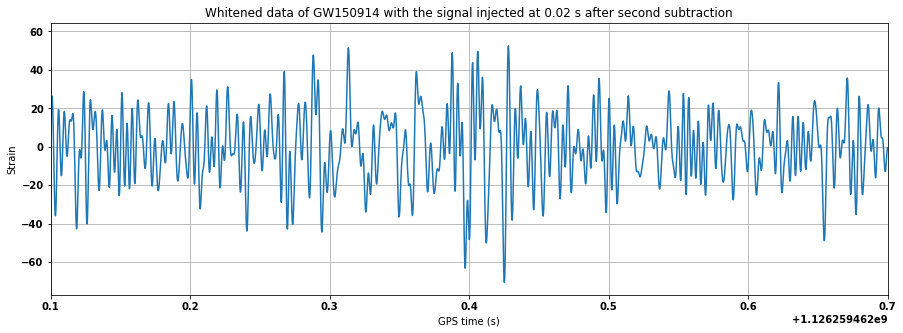

In [52]:
#whitening of the data
white_sigSS02 =  (subsubF02/psdS2**0.5).to_timeseries()
white_sigSS02 = white_sigSS02.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sigSS02 = white_sigSS02.time_slice(merger.time - 5, merger.time + 5)

plt.figure(figsize = [15, 5])
plt.plot(white_sigSS02.sample_times, white_sigSS02)
plt.xlim(merger.time - 0.3, merger.time + .3)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()
plt.title("Whitened data of GW150914 with the signal injected at 0.02 s after second subtraction")

The signal is far less clearly present but still wwe see some variations that could be interpreted as a GW. We will do a **best fit** procedure to see if the signal can be subtracted or not

In [53]:
def gen_template(theta, delta_t = subsub02.delta_t, 
                 duration = subsub02.duration, start_time = subsub02.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - subsub02.start_time)
    hp.start_time = subsub02.start_time
    
    return hp

In [54]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = subsubF02, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psdSS02[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psdSS02[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [55]:
def whiten_trim_template(template, psd = psdSS02):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (subsubF02/psdSS02**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psdSS02 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 5)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + 0.2)
    if zoom is False:
        plt.xlim(merger.time - 0.5, merger.time + 0.5)
        

-613.901852286214


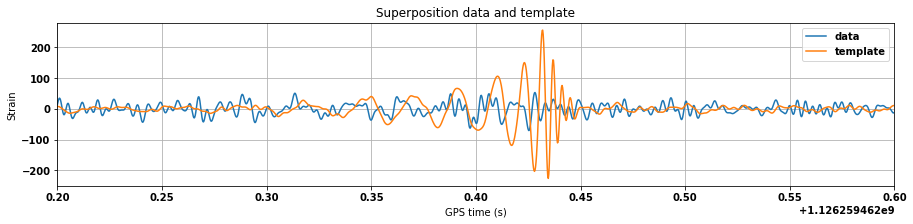

In [56]:
theta0S2 = [m1maxSS02, m2maxSS02, 440, tmaxSS02]

temp0S2 = gen_template(theta0S2)
plot_white_strain(subsub02, temp0S2, True)

print(loglikelihood(theta0S2))

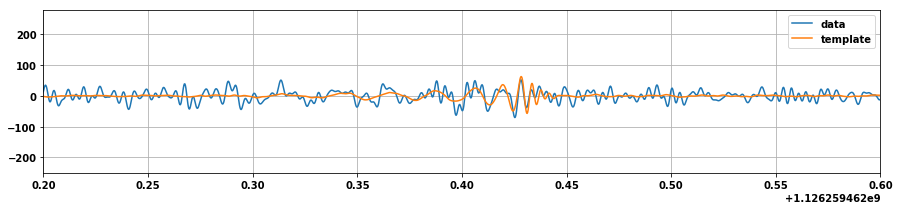

Steps 	 log(likelihood)
6 	 34.096


In [57]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0S2))

plt.plot(white_sigSS02.sample_times, white_sigSS02, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0S2, 
              callback = callback, method = 'powell')
plt.close()

[3.91018313e+01 3.23958786e+01 1.78008433e+03 1.12625946e+09]


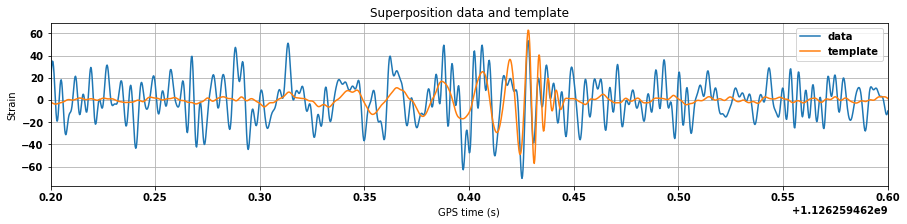

In [59]:
paramSS02 = res.x
print(paramSS02)
bestSubS02 = gen_template(paramSS02)
plot_white_strain(subsub02, bestSubS02, True)

Text(0,0.5,'Normalized amplitude')

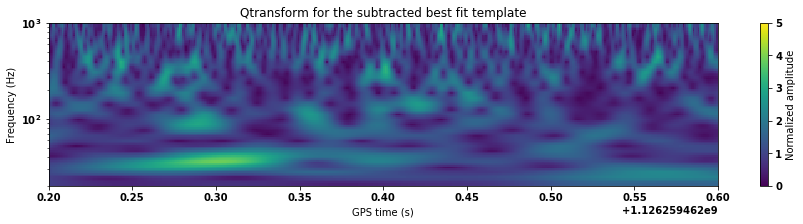

In [61]:
subsubS02 = subsub02 - bestSubS02

t, f, p = subsubS02.whiten(2,2).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

we see that the subtraction is less well done, even after the best subtraction. The event cannot be found correctly any more

Now, we can see if the subtraction would have been better if we allowed bigger masses at the start. The idea would be to find 1 or 2 events but as a huge meger.

## 1 big event

In [62]:
merger = Merger("GW150914")
strain = merger.strain("H1")
strain = highpass(strain, 15)
strain = strain.crop(2,2)

strainF = strain.to_frequencyseries()

In [63]:
# making the signal with the injection at 0.02 sec
time_shifts = np.arange(5, 20, 0.01)

model_inj = None
max_amp_inj, time_inj, time_dif = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                              mass2 = 32.3, distance = 440, f_lower = 20.,
                              delta_t = strain.delta_t)
    hpInj.resize(len(strain))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strain.start_time
    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_ev = hpInj.sample_times[ind]
    time_diff = time_ev - merger.time
    if (abs(time_diff - 0.02) < 0.01):
        model_inj = hpInj
        max_amp_inj, time_inj, time_dif_inj = max_amp, time_ev, time_diff


In [64]:
#infos about the injection
print("Max amplitude: ", max_amp_inj)
print("time of the merger for the injection: ", time_inj)
print("Time gap between merger and injection: ", time_dif_inj)

('Max amplitude: ', 1.820726655022926e-21)
('time of the merger for the injection: ', 1126259462.4284668)
('Time gap between merger and injection: ', 0.02846670150756836)


In [65]:
#now we add the injection in the strain 

sig02 = strain + model_inj

sigF02 = sig02.to_frequencyseries()

p0 = sig02.psd(2)
p0 = interpolate(p0, sig02.delta_f)
psd02 = inverse_spectrum_truncation(p0, 2*sig02.sample_rate, 
                                 low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

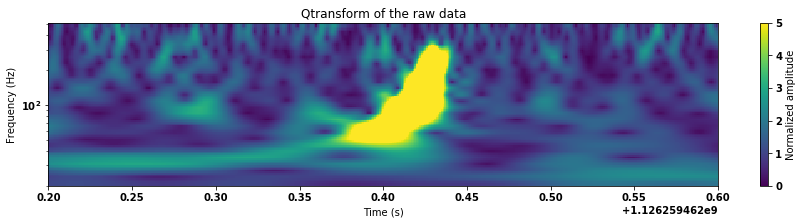

In [66]:
zoom = sig02.whiten(2,2).time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,512),
                             qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [69]:
mass1 = np.arange(20, 101, 1)
mass2 = np.arange(30, 58, 1)

print(len(mass1))
print(len(mass2))

81
28


In [70]:
import numpy as np

mass1 = np.arange(20, 101, 1)
mass2 = np.arange(30, 58, 1)

hmax02 = None
maxsnr02, m1max02, m2max02, tmax02 = 0, 0, 0, 0

snrs02 = [[] for i in range(len(mass1))]
max_snrs02 = [[] for i in range(len(mass1))]
times_max02 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF02.delta_f)
        hp.resize(len(sigF02))
        
        snr = matched_filter(hp, sigF02, psd = psd02, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 5, merger.time + 5)
        snrs02[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs02[i].append(snrp)
        time = snr.sample_times[idx]
        times_max02[i].append(time)
        
        # Keep track of the max snr
        
        if snrp > maxsnr02:
            tmax02, hmax02, m1max02, m2max02, maxsnr02 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1max02, m2max02, tmax02, maxsnr02))
print(time_inj)

mass 1 1/81
Done
mass 1 2/81
Done
mass 1 3/81
Done
mass 1 4/81
Done
mass 1 5/81
Done
mass 1 6/81
Done
mass 1 7/81
Done
mass 1 8/81
Done
mass 1 9/81
Done
mass 1 10/81
Done
mass 1 11/81
Done
mass 1 12/81
Done
mass 1 13/81
Done
mass 1 14/81
Done
mass 1 15/81
Done
mass 1 16/81
Done
mass 1 17/81
Done
mass 1 18/81
Done
mass 1 19/81
Done
mass 1 20/81
Done
mass 1 21/81
Done
mass 1 22/81
Done
mass 1 23/81
Done
mass 1 24/81
Done
mass 1 25/81
Done
mass 1 26/81
Done
mass 1 27/81
Done
mass 1 28/81
Done
mass 1 29/81
Done
mass 1 30/81
Done
mass 1 31/81
Done
mass 1 32/81
Done
mass 1 33/81
Done
mass 1 34/81
Done
mass 1 35/81
Done
mass 1 36/81
Done
mass 1 37/81
Done
mass 1 38/81
Done
mass 1 39/81
Done
mass 1 40/81
Done
mass 1 41/81
Done
mass 1 42/81
Done
mass 1 43/81
Done
mass 1 44/81
Done
mass 1 45/81
Done
mass 1 46/81
Done
mass 1 47/81
Done
mass 1 48/81
Done
mass 1 49/81
Done
mass 1 50/81
Done
mass 1 51/81
Done
mass 1 52/81
Done
mass 1 53/81
Done
mass 1 54/81
Done
mass 1 55/81
Done
mass 1 56/81
Done
m

The result is not for the maximum values here, so we can say that those correspond to the best parameters. In order to see, we can try to subtract it directly and/or with a best fit procedure before

Text(0,0.5,'Normalized amplitude')

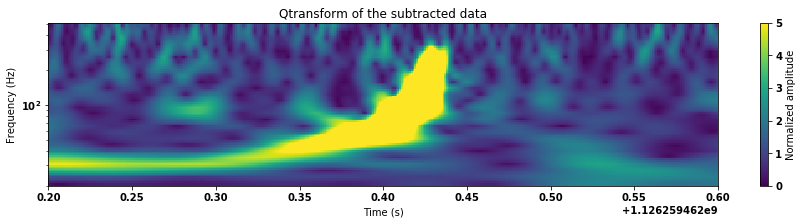

In [71]:
#subtraction of the signal to see if it works

dt = tmax02 - sigF02.start_time
inj = hmax02.cyclic_time_shift(dt)

#scaling of the template 
inj /= sigma(hmax02, psd = psd02, low_frequency_cutoff = 20.)
inj *= maxsnr02

#subtraction
subF02 = sigF02 - inj

#whiten
subT_white02 = (subF02/psd02**0.5).to_timeseries()
zoom = subT_white02.time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

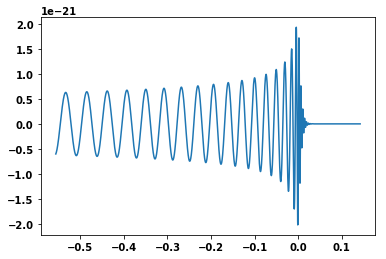

In [72]:
#strting model that wil be adjusted:

hp_st02, hf_st02 = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1max02,
                              mass2 = m2max02, distance = 440, delta_t = sig02.delta_t,
                              f_lower = f_low)
plt.plot(hp_st02.sample_times, hp_st02)

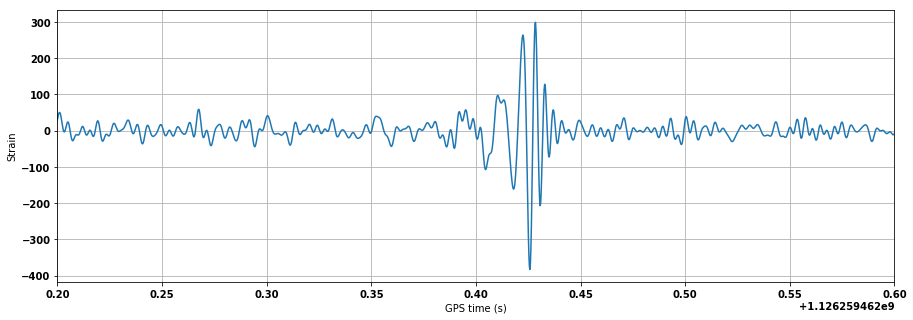

In [73]:
#whitening of the data
white_sig02 =  (sigF02/psd02**0.5).to_timeseries()
white_sig02 = white_sig02.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sig02 = white_sig02.time_slice(merger.time - 5, merger.time + 5)

plt.figure(figsize = [15, 5])
plt.plot(white_sig02.sample_times, white_sig02)
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()

In [74]:
def gen_template(theta, delta_t = sig02.delta_t, 
                 duration = sig02.duration, start_time = sig02.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sig02.start_time)
    hp.start_time = sig02.start_time
    
    return hp

In [75]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = sigF02, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psd02[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd02[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [76]:
def whiten_trim_template(template, psd = psd02):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd02**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (sigF02/psd02**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd02 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 5)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + 0.2)
    if zoom is False:
        plt.xlim(merger.time - 0.5, merger.time + 0.5)
        

-1130.1202811499454


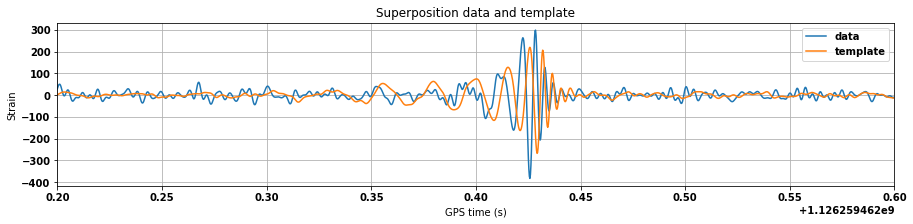

In [77]:
theta0 = [m1max02, m2max02, 440, tmax02]

temp0 = gen_template(theta0)
plot_white_strain(sig02, temp0, True)

print(loglikelihood(theta0))

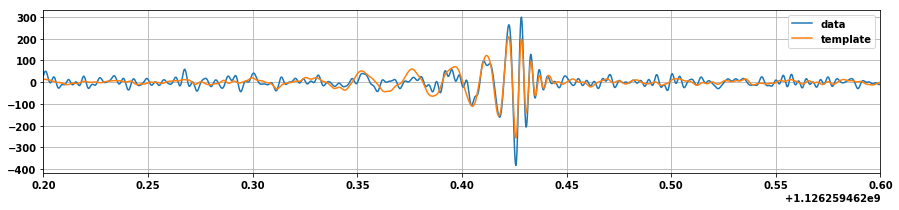

Steps 	 log(likelihood)
7 	 603.569


In [78]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sig02.sample_times, white_sig02, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[3.75011497e+01 3.74911105e+01 4.59691379e+02 1.12625946e+09]


Text(0.5,1,'Superposition sugnal and best fit template')

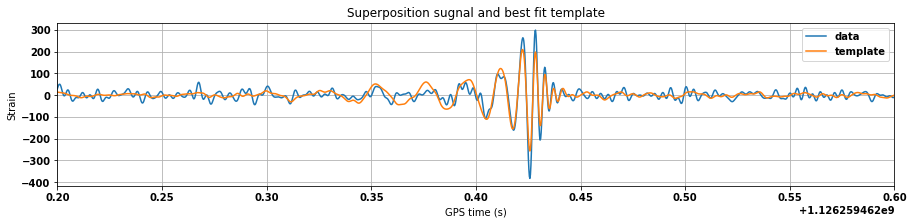

In [79]:
para02 = res.x
print(para02)
best_temp02 = gen_template(para02)
plot_white_strain(sig02, best_temp02, True)
plt.title("Superposition sugnal and best fit template")

Text(0,0.5,'Normalized amplitude')

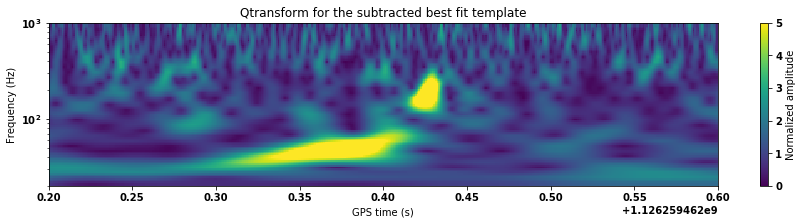

In [80]:
#try to subtract the best fit template to see if it works

sub02 = sig02 - best_temp02

t, f, p = sub02.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

The subtraction is still not well done. So, we can try to see if we can find a second signal or not. Nevertheless, te conclusion is that the matched filter cannot work well anymore here 

In [81]:
#psd of the subtracted data
pS2 = sub02.psd(2)
pS2 = interpolate(pS2, sub02.delta_f)
psdS2 = inverse_spectrum_truncation(pS2, 2*sub02.sample_rate, 
                                  low_frequency_cutoff = 15.,
                                  trunc_method = 'hann')


In [82]:
#subtracted signal in the frequency domain
subF02 = sub02.to_frequencyseries()

In [84]:
#matched filtering for the event

mass1 = np.arange(20, 101, 1)
mass2 = np.arange(30, 58, 1)

hmaxS02 = None
maxsnrS02, m1maxS02, m2maxS02, tmaxS02 = 0, 0, 0, 0

snrsS02 = [[] for i in range(len(mass1))]
max_snrsS02 = [[] for i in range(len(mass1))]
time_maxS02 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1,len(mass1)))
    for m2 in mass2:
        #template generation
        hp, _ = get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = subF02.delta_f)
        hp.resize(len(subF02))
        
        #matched filtering
        snr = matched_filter(hp, subF02, psd = psdS2, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrsS02[i].append(snr)
        ind = abs(snr).numpy().argmax()
        snrp = abs(snr[ind])
        max_snrsS02[i].append(snrp)
        time = snr.sample_times[ind]
        time_maxS02[i].append(time)
        
        #keep track of max snr
        
        if snrp > maxsnrS02:
            tmaxS02, hmaxS02, m1maxS02, m2maxS02, maxsnrS02 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a value of %.7f" %(m1maxS02, m2maxS02, tmaxS02, maxsnrS02))
print(merger.time)

Mass 1: 1/81
Done
Mass 1: 2/81
Done
Mass 1: 3/81
Done
Mass 1: 4/81
Done
Mass 1: 5/81
Done
Mass 1: 6/81
Done
Mass 1: 7/81
Done
Mass 1: 8/81
Done
Mass 1: 9/81
Done
Mass 1: 10/81
Done
Mass 1: 11/81
Done
Mass 1: 12/81
Done
Mass 1: 13/81
Done
Mass 1: 14/81
Done
Mass 1: 15/81
Done
Mass 1: 16/81
Done
Mass 1: 17/81
Done
Mass 1: 18/81
Done
Mass 1: 19/81
Done
Mass 1: 20/81
Done
Mass 1: 21/81
Done
Mass 1: 22/81
Done
Mass 1: 23/81
Done
Mass 1: 24/81
Done
Mass 1: 25/81
Done
Mass 1: 26/81
Done
Mass 1: 27/81
Done
Mass 1: 28/81
Done
Mass 1: 29/81
Done
Mass 1: 30/81
Done
Mass 1: 31/81
Done
Mass 1: 32/81
Done
Mass 1: 33/81
Done
Mass 1: 34/81
Done
Mass 1: 35/81
Done
Mass 1: 36/81
Done
Mass 1: 37/81
Done
Mass 1: 38/81
Done
Mass 1: 39/81
Done
Mass 1: 40/81
Done
Mass 1: 41/81
Done
Mass 1: 42/81
Done
Mass 1: 43/81
Done
Mass 1: 44/81
Done
Mass 1: 45/81
Done
Mass 1: 46/81
Done
Mass 1: 47/81
Done
Mass 1: 48/81
Done
Mass 1: 49/81
Done
Mass 1: 50/81
Done
Mass 1: 51/81
Done
Mass 1: 52/81
Done
Mass 1: 53/81
Done
Ma

Text(0,0.5,'Normalized amplitude')

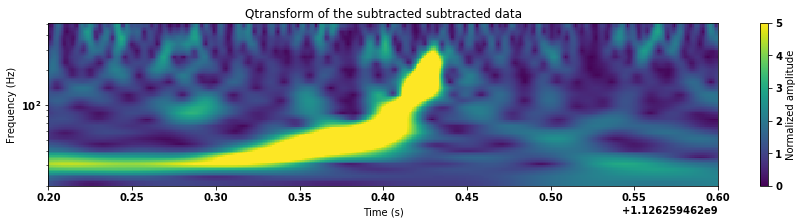

In [85]:
dt = tmaxS02 - subF02.start_time
inj = hmaxS02.cyclic_time_shift(dt)

#scale tempplate

inj /= sigma(hmaxS02, psd = psdS2, low_frequency_cutoff = 20.)
inj *= maxsnrS02

subsubF02 = subF02 - inj

#whiten 

subsub_white02 = (subsubF02/psdS2**0.5).to_timeseries()
zoom = subsub_white02.time_slice(merger.time -2, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))

plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

Text(0.5,1,'Whitened data of GW150914 with the signal injected at 0.02 s after first subtraction')

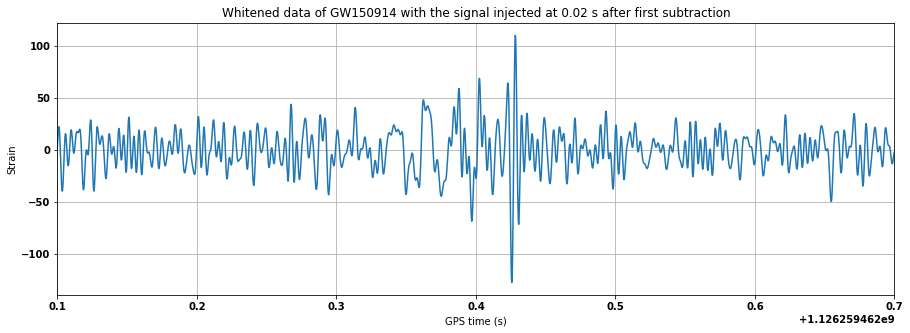

In [86]:
#whitening of the data
white_sigS02 =  (subF02/psdS2**0.5).to_timeseries()
white_sigS02 = white_sigS02.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sigS02 = white_sigS02.time_slice(merger.time - 5, merger.time + 5)

plt.figure(figsize = [15, 5])
plt.plot(white_sigS02.sample_times, white_sigS02)
plt.xlim(merger.time - 0.3, merger.time + .3)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()
plt.title("Whitened data of GW150914 with the signal injected at 0.02 s after first subtraction")

In [87]:
def gen_template(theta, delta_t = sub02.delta_t, 
                 duration = sub02.duration, start_time = sub02.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sub02.start_time)
    hp.start_time = sub02.start_time
    
    return hp

In [88]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = subF02, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psdS2[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psdS2[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [89]:
def whiten_trim_template(template, psd = psdS2):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (subF02/psdS2**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psdS2 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 5)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + 0.2)
    if zoom is False:
        plt.xlim(merger.time - 0.5, merger.time + 0.5)
        

-639.6266516366577


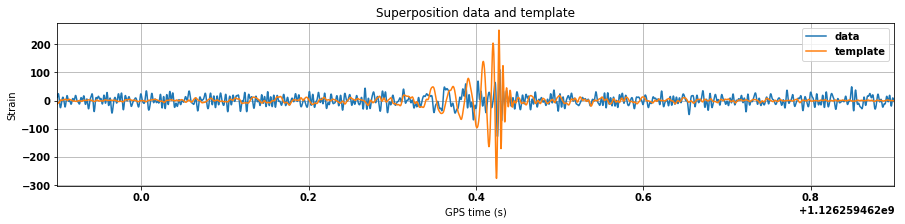

In [90]:
theta0 = [m1maxS02, m2maxS02, 440, tmaxS02]

temp0 = gen_template(theta0)
plot_white_strain(sub02, temp0, False)

print(loglikelihood(theta0))

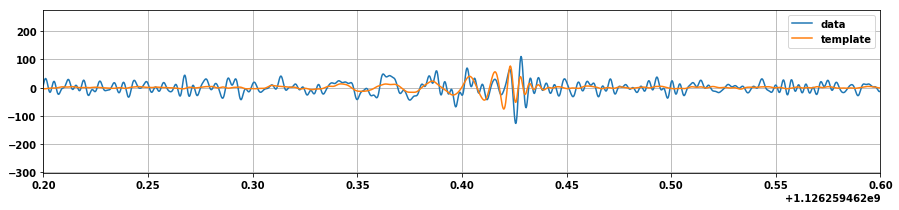

Steps 	 log(likelihood)
14 	 58.296


In [91]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sigS02.sample_times, white_sigS02, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[3.75692093e+01 3.91925448e+01 1.51906451e+03 1.12625946e+09]


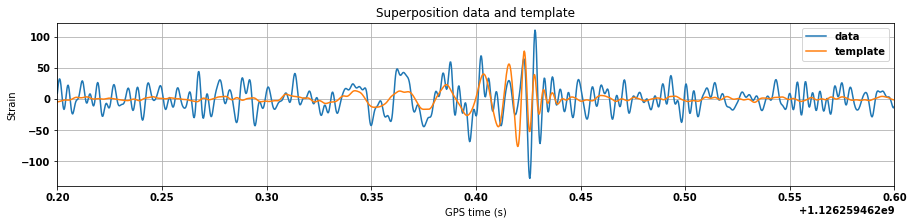

In [92]:
paramS02 = res.x
print(paramS02)
bestSub02 = gen_template(paramS02)
plot_white_strain(sub02, bestSub02, True)

Text(0,0.5,'Normalized amplitude')

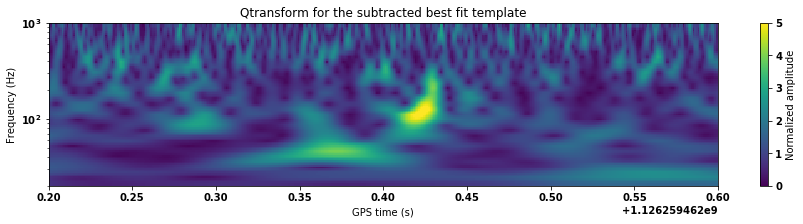

In [93]:
subsub02 = sub02 - bestSub02

t, f, p = subsub02.whiten(2,2).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

At the end we see that none of the two options give a convincing solution, which shows that there is a problem with the analysis.